In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.datasets as datasets
from art.attacks.evasion import BasicIterativeMethod
from art.estimators.classification import PyTorchClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from region_based_classifier import RegionBasedClassifier
from util import dataset2tensor, get_correct_examples

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

n_threads = os.cpu_count()
print('CPU threads: {}'.format(n_threads))

Device: cuda
CPU threads: 24


In [4]:
PATH = 'data'
BATCH_SIZE = 128
EPOCHS = 20
N_ADV = 2000

In [5]:
# Fetch dataset
transforms = tv.transforms.Compose([tv.transforms.ToTensor()])
dataset_train = datasets.MNIST(PATH, train=True, download=True, transform=transforms)
dataset_test = datasets.MNIST(PATH, train=False, download=True, transform=transforms)

# From PyTorch dataset to Numpy array
tensor_X_train, tensor_y_train = dataset2tensor(dataset_train)
X_train = tensor_X_train.cpu().detach().numpy()
y_train = tensor_y_train.cpu().detach().numpy()

# Split model training set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=5000)
dataset_train = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.int64))

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
print(len(dataset_train))
print(dataset_test.data.size())

55000
torch.Size([10000, 28, 28])


## Train point-based classifier

In [7]:
# Create Neural Network model
model = nn.Sequential(
    nn.Conv2d(1, 32, 3, 1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(9216, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.LogSoftmax(dim=1)
)
model.to(device)
print('Number of layers: {}'.format(len(list(model.children()))))

Number of layers: 10


In [8]:
def train(model, loader, loss, optimizer):
    model.train()
    total_loss = 0.
    corrects = 0.
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        optimizer.zero_grad()
        outputs = model(x)
        l = loss(outputs, y)
        l.backward()
        optimizer.step()

        # for display
        total_loss += l.item() * batch_size
        preds = outputs.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [9]:
def validate(model, loader, loss, device=device):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            outputs = model(x)
            l = loss(outputs, y)
            total_loss += l.item() * batch_size
            preds = outputs.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [10]:
def predict(model, X, batch_size=BATCH_SIZE, device=device):
    model.eval()
    dataset = TensorDataset(X)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    tensor_pred = -torch.ones(len(X), dtype=torch.int64)
    
    start = 0
    with torch.no_grad():
        for x in loader:
            x = x[0].to(device)
            n = x.size(0)
            end = start + n
            outputs = model(x)
            tensor_pred[start:end] = outputs.max(1)[1].type(torch.int64)
            start += n

    return tensor_pred

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss=nn.NLLLoss()

In [12]:
since = time.time()
for epoch in range(EPOCHS):
    start = time.time()
    tr_loss, tr_acc = train(model, dataloader_train, loss, optimizer)
    va_loss, va_acc = validate(model, dataloader_test, loss)
    
    time_elapsed = time.time() - start
    print(('[{:2d}] {:.0f}m {:.1f}s Train Loss: {:.4f} Accuracy: {:.4f}%, ' +
        'Test Loss: {:.4f} Accuracy: {:.4f}%').format(
            epoch+1, time_elapsed // 60, time_elapsed % 60,
            tr_loss, tr_acc*100.,
            va_loss, va_acc*100.))
    
time_elapsed = time.time() - since
print('Total run time: {:.0f}m {:.1f}s'.format(
    time_elapsed // 60,
    time_elapsed % 60))

[ 1] 0m 2.1s Train Loss: 0.4020 Accuracy: 88.2055%, Test Loss: 0.1485 Accuracy: 95.4200%
[ 2] 0m 2.1s Train Loss: 0.1337 Accuracy: 95.8145%, Test Loss: 0.1084 Accuracy: 96.5500%
[ 3] 0m 2.1s Train Loss: 0.0907 Accuracy: 97.1764%, Test Loss: 0.0884 Accuracy: 97.2200%
[ 4] 0m 2.1s Train Loss: 0.0651 Accuracy: 97.9564%, Test Loss: 0.0818 Accuracy: 97.3700%
[ 5] 0m 2.2s Train Loss: 0.0495 Accuracy: 98.4927%, Test Loss: 0.0531 Accuracy: 98.1800%
[ 6] 0m 2.1s Train Loss: 0.0390 Accuracy: 98.7655%, Test Loss: 0.0481 Accuracy: 98.4900%
[ 7] 0m 2.2s Train Loss: 0.0320 Accuracy: 98.9873%, Test Loss: 0.0430 Accuracy: 98.6600%
[ 8] 0m 2.1s Train Loss: 0.0248 Accuracy: 99.2545%, Test Loss: 0.0475 Accuracy: 98.5200%
[ 9] 0m 2.1s Train Loss: 0.0194 Accuracy: 99.4073%, Test Loss: 0.0417 Accuracy: 98.6300%
[10] 0m 2.1s Train Loss: 0.0155 Accuracy: 99.5891%, Test Loss: 0.0442 Accuracy: 98.5800%
[11] 0m 2.1s Train Loss: 0.0127 Accuracy: 99.6309%, Test Loss: 0.0493 Accuracy: 98.4100%
[12] 0m 2.1s Train Lo

## Remove missclassified samples

In [13]:
print('Training set: {}'.format(len(dataset_train)))
tensor_train_X, tensor_train_y = get_correct_examples(model, dataset_train, device=device, return_tensor=True)
dataset_train_perfect = TensorDataset(tensor_train_X, tensor_train_y)
dataloader_train_perfect = DataLoader(dataset_train_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_train_perfect, loss)
print('Accuracy on {} filtered training examples: {:.4f}%'.format(len(dataloader_train_perfect.dataset), acc*100))

print('Test set: {}'.format(len(dataset_test)))
tensor_test_X, tensor_test_y = get_correct_examples(model, dataset_test, device=device, return_tensor=True)
dataset_test_perfect = TensorDataset(tensor_test_X, tensor_test_y)
dataloader_test_perfect = DataLoader(dataset_test_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_test_perfect, loss)
print('Accuracy on {} filtered test examples: {:.4f}%'.format(len(dataloader_test_perfect.dataset), acc*100))

Training set: 55000
Accuracy on 54979 filtered training examples: 100.0000%
Test set: 10000
Accuracy on 9870 filtered test examples: 100.0000%


## Create adversarial examples 

In [14]:
classifier = PyTorchClassifier(
    model=model, 
    loss=loss, 
    input_shape=(1, 28, 28), 
    optimizer=optimizer,
    nb_classes=10,
    clip_values=(0.0, 1.0),
    device_type=device
)

# attack = FastGradientMethod(estimator=classifier, eps=0.2)
attack = BasicIterativeMethod(estimator=classifier, eps=0.2)

In [15]:
# Prepare dataset for adversarial examples
n = len(dataset_test_perfect)
indices = torch.randperm(n)[:N_ADV]

pt_subset_X = tensor_test_X[indices]  # PyTorch Tensor
pt_subset_y = tensor_test_y[indices]

subset_X = pt_subset_X.cpu().detach().numpy()
subset_y = pt_subset_y.cpu().detach().numpy()

In [16]:
# Create adversarial examples
subset_pred = np.argmax(classifier.predict(subset_X), axis=1)
accuracy = np.sum(subset_pred == subset_y) / float(len(subset_pred))
print("Model accuracy on clean examples: {:.4f}%".format(accuracy * 100))

# Generate adversarial examples
subset_adv = attack.generate(x=subset_X)
subset_pred = np.argmax(classifier.predict(subset_adv), axis=1)

accuracy = np.sum(subset_pred == subset_y) / float(len(subset_pred))
print("Model accuracy on adversarial examples: {:.4f}%".format(accuracy * 100))

PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]Model accuracy on clean examples: 100.0000%
Model accuracy on adversarial examples: 9.4000%


## Region-based classification

In [31]:
X_benign = subset_X[:1000]
X_adv = subset_adv[:1000]
y_true = subset_y[:1000]

print('Test set (Adversarial examples):', X_adv.shape)
print('Test set (True labels) :', y_true.shape)

print('Validation set (Benign samples):', X_val.shape)
print('Validation set (True labels) :', y_val.shape)

Test set (Adversarial examples): (1000, 1, 28, 28)
Test set (True labels) : (1000,)
Validation set (Benign samples): (5000, 1, 28, 28)
Validation set (True labels) : (5000,)


In [50]:
rb_classifier = RegionBasedClassifier(
    model=model,
    r=0.3,
    sample_size=1000,
    n_class=10,
    clip_values=(0.0, 1.0),
    batch_size=128,
    device=device)

## Learn hyper-parameter r

In [42]:
R0 = 0.0
STEP_SIZE = 0.02
STOP_VALUE = 0.40

In [48]:
tensor_pred_val = predict(model, torch.tensor(X_val[:1000], dtype=torch.float32))
pred_val = tensor_pred_val.cpu().detach().numpy()
acc_pb = np.sum(pred_val == y_val[:1000]) / float(len(pred_val))

print('Accuracy on validation set: {:.4f}'.format(acc_pb))

Accuracy on validation set: 0.9830


In [51]:
r_best, r_history = rb_classifier.search_r(
    X_val[:1000],
    y_val[:1000],
    r0=R0,
    step_size=STEP_SIZE,
    stop=STOP_VALUE,
    update=False,
    verbose=1)

Accuracy on validation set: 0.9830
[0:00:15.328741] Accuracy on region-based: 0.9830, r: 0.00
[0:00:18.040609] Accuracy on region-based: 0.9830, r: 0.02
[0:00:19.096297] Accuracy on region-based: 0.9830, r: 0.04
[0:00:18.620085] Accuracy on region-based: 0.9830, r: 0.06
[0:00:18.269924] Accuracy on region-based: 0.9830, r: 0.08
[0:00:18.205754] Accuracy on region-based: 0.9830, r: 0.10
[0:00:18.268327] Accuracy on region-based: 0.9830, r: 0.12
[0:00:18.254508] Accuracy on region-based: 0.9830, r: 0.14
[0:00:18.109600] Accuracy on region-based: 0.9820, r: 0.16
[0:00:18.337696] Accuracy on region-based: 0.9830, r: 0.18
[0:00:18.672847] Accuracy on region-based: 0.9820, r: 0.20
[0:00:18.832404] Accuracy on region-based: 0.9810, r: 0.22
[0:00:18.641474] Accuracy on region-based: 0.9810, r: 0.24
[0:00:18.681483] Accuracy on region-based: 0.9810, r: 0.26
[0:00:18.645984] Accuracy on region-based: 0.9810, r: 0.28
[0:00:18.963168] Accuracy on region-based: 0.9810, r: 0.30
[0:00:18.969922] Accu

In [52]:
print(r_best)

0.19999999999999998


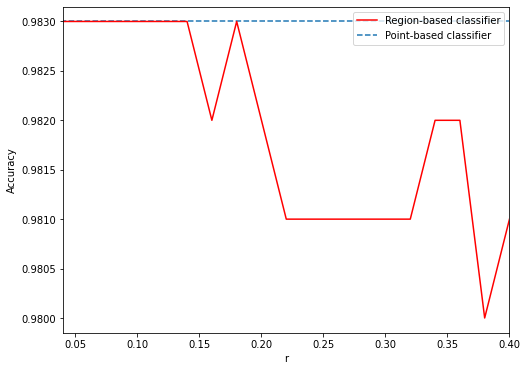

In [53]:
plt.figure(figsize=(8, 6))
plt.hlines([acc_pb], xmin=R0, xmax=STOP_VALUE, linestyles='dashed', label='Point-based classifier')
plt.plot(r_history[:, 0], r_history[:, 1], c='red', label='Region-based classifier')
plt.xlim(0.04, 0.4)
plt.xlabel('r')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [64]:
# Update r
rb_classifier.set_params(r=r_best)
print(rb_classifier.r)

0.19999999999999998


## Test region-based classifier

In [65]:
pred_adv = np.argmax(classifier.predict(X_adv), axis=1)
pred_rb = rb_classifier.predict(X_adv)
pred_benign = rb_classifier.predict(X_benign)

print('True labels:                             ', y_true[:10])
print('Predictions from point-based classifier: ', pred_adv[:10])
print('Predictions from region-based classifier:', pred_rb[:10])

True labels:                              [3 4 2 2 2 7 1 6 4 4]
Predictions from point-based classifier:  [9 7 1 0 7 9 8 6 4 1]
Predictions from region-based classifier: [3 7 1 0 7 7 8 6 4 1]


In [66]:
accuracy = np.sum(pred_adv == y_true) / float(len(X_adv))
print("Model accuracy of adversarial examples on point-based classifier: {:.4f}%".format(accuracy * 100))

accuracy = np.sum(pred_rb == y_true) / float(len(X_adv))
print("Model accuracy of adversarial examples on regin-based classifier: {:.4f}%".format(accuracy * 100))

accuracy = np.sum(pred_benign == y_true) / float(len(X_adv))
print("Model accuracy of benign samples on regin-based classifier: {:.4f}%".format(accuracy * 100))

Model accuracy of adversarial examples on point-based classifier: 10.0000%
Model accuracy of adversarial examples on regin-based classifier: 19.4000%
Model accuracy of benign samples on regin-based classifier: 100.0000%


In [67]:
prob_rb = rb_classifier.predict_proba(X_adv[:10])
print(prob_rb)

[[0.    0.    0.    0.579 0.    0.    0.    0.    0.    0.421]
 [0.    0.    0.    0.    0.004 0.    0.    0.996 0.    0.   ]
 [0.    0.988 0.012 0.    0.    0.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.092 0.    0.    0.    0.    0.908 0.    0.   ]
 [0.    0.    0.    0.119 0.    0.    0.    0.575 0.    0.306]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.033 0.967 0.    0.    0.   ]
 [0.    0.    0.    0.    0.998 0.    0.    0.002 0.    0.   ]
 [0.    0.859 0.    0.    0.141 0.    0.    0.    0.    0.   ]]
